In [24]:
%matplotlib inline
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt

In [25]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.3.0
torch==1.13.0+cu117
matplotlib==3.6.2


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [27]:
#load data
data = pd.read_csv("..\..\..\Data\Hour\sand500_MinuteToHour.csv")

In [28]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.Close = data.Close.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)

In [29]:
data.head()

,Date,Open,High,Low,Close
0,2010-01-04 10:00:00,1128.26,1128.35,1128.26,1128.30
1,2010-01-04 11:00:00,1131.83,1131.94,1131.83,1131.94
2,2010-01-04 12:00:00,1133.41,1133.41,1133.15,1133.15
3,2010-01-04 13:00:00,1133.06,1133.06,1133.01,1133.01
4,2010-01-04 14:00:00,1131.75,1131.75,1131.64,1131.64


In [30]:
data.index = data.index[::-1]

In [31]:
data.head()

,Date,Open,High,Low,Close
34977,2010-01-04 10:00:00,1128.26,1128.35,1128.26,1128.30
34976,2010-01-04 11:00:00,1131.83,1131.94,1131.83,1131.94
34975,2010-01-04 12:00:00,1133.41,1133.41,1133.15,1133.15
34974,2010-01-04 13:00:00,1133.06,1133.06,1133.01,1133.01
34973,2010-01-04 14:00:00,1131.75,1131.75,1131.64,1131.64


In [32]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]

In [33]:
special_data.head()

,Date,Open,High,Low,Close
34977,2010-01-04 10:00:00,1128.26,1128.35,1128.26,1128.30
34976,2010-01-04 11:00:00,1131.83,1131.94,1131.83,1131.94
34975,2010-01-04 12:00:00,1133.41,1133.41,1133.15,1133.15
34974,2010-01-04 13:00:00,1133.06,1133.06,1133.01,1133.01
34973,2010-01-04 14:00:00,1131.75,1131.75,1131.64,1131.64


In [34]:
#change indexes
special_data.set_index('Date', inplace=True)

In [35]:
special_data = special_data.drop(columns=['Open', 'High', 'Low'])

In [36]:
special_data = special_data.dropna()

In [37]:
special_data.head()

,Close
Date,
2010-01-04 10:00:00,1128.30
2010-01-04 11:00:00,1131.94
2010-01-04 12:00:00,1133.15
2010-01-04 13:00:00,1133.01
2010-01-04 14:00:00,1131.64


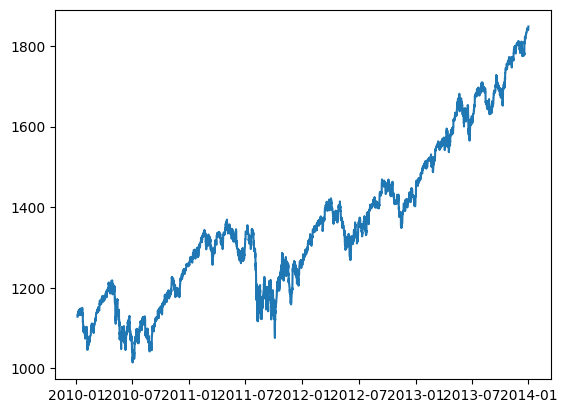

In [38]:
plt.plot(special_data)

In [39]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
val_size = 100
test_size = len(y) - train_size - val_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x) - val_size)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y) - val_size)])).to(device))

valX = Variable(torch.Tensor(np.array(x[(len(x) - val_size):len(x)])).to(device))
valY = Variable(torch.Tensor(np.array(y[(len(x) - val_size):len(y)])).to(device))

In [40]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [41]:
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUNet, self).__init__()

        # set parameters
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # define layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_dim)).to(device)

        # forward propagate GRU
        out, _ = self.gru(x, h0)

        # decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/200], Train Loss: 0.0454, Valid Loss: 0.0145
Epoch [11/200], Train Loss: 0.0223, Valid Loss: 0.1029
Epoch [21/200], Train Loss: 0.0094, Valid Loss: 0.0447
Epoch [31/200], Train Loss: 0.0018, Valid Loss: 0.0004
Epoch [41/200], Train Loss: 0.0010, Valid Loss: 0.0114
Epoch [51/200], Train Loss: 0.0002, Valid Loss: 0.0005
Epoch [61/200], Train Loss: 0.0001, Valid Loss: 0.0020
Epoch [71/200], Train Loss: 0.0001, Valid Loss: 0.0006
Epoch [81/200], Train Loss: 0.0000, Valid Loss: 0.0008
Epoch [91/200], Train Loss: 0.0000, Valid Loss: 0.0006
Epoch [101/200], Train Loss: 0.0000, Valid Loss: 0.0007
Epoch [111/200], Train Loss: 0.0000, Valid Loss: 0.0005
Epoch [121/200], Train Loss: 0.0000, Valid Loss: 0.0006
Epoch [131/200], Train Loss: 0.0000, Valid Loss: 0.0005
Epoch [141/200], Train Loss: 0.0000, Valid Loss: 0.0005
Epoch [151/200], Train Loss: 0.0000, Valid Loss: 0.0005
Epoch [161/200], Train Loss: 0.0000, Valid Loss: 0.0004
Epoch [171/200], Train Loss: 0.0000, Valid Loss: 0.0004
Epo

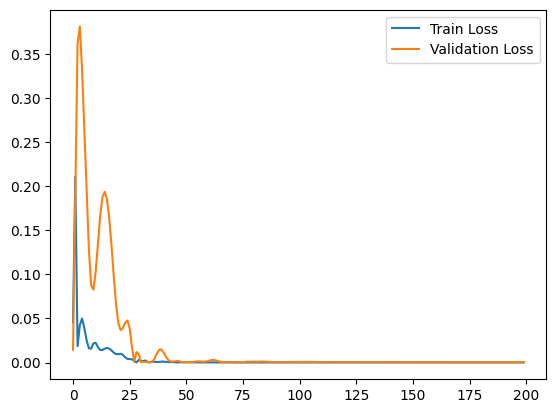

In [42]:
input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 2
learning_rate = 0.01
num_epochs = 200

num_classes = 1

model = GRUNet(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    # set the model to train mode
    model.train()

    # forward pass
    output = model(trainX)
    loss = criterion(output, trainY)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate training loss
    train_loss.append(loss.item())

    # set the model to evaluation mode
    model.eval()

    # calculate validation loss
    with torch.no_grad():
        output = model(testX)
        loss = criterion(output, testY)
        valid_loss.append(loss.item())

    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(testX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())

test_score = np.sqrt(mean_squared_error(testY_inv, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

Test RMSE Score: 15.97


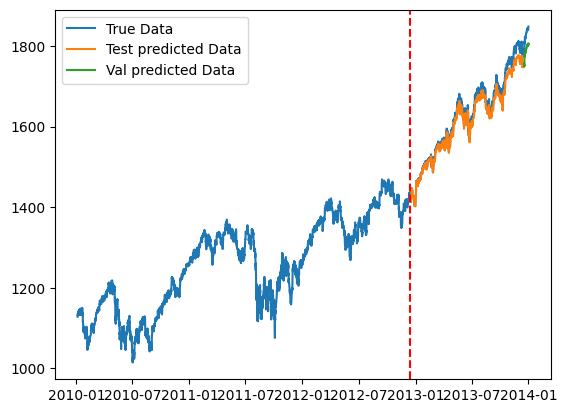

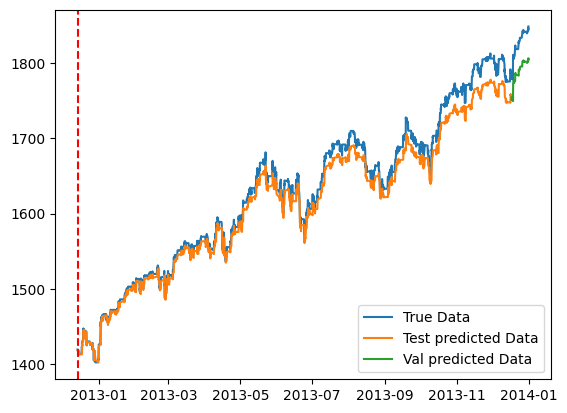

In [45]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(special_data, label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[-len(predY_test_inv)- val_size:], special_data.Close[-len(predY_test_inv)- val_size:], label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()

In [46]:
deviations = np.abs(testY_inv - test_predict_inv)
max_deviation = np.max(deviations)

In [47]:
print(max_deviation)

45.655518


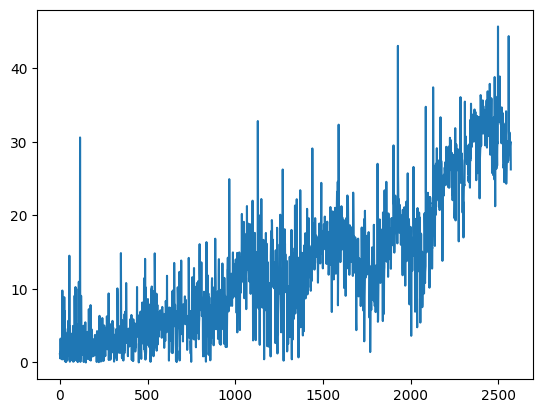

In [48]:
plt.plot(deviations)

In [49]:
percent_deviations = (testY_inv - test_predict_inv) / testY_inv
max_percent_deviations = np.max(percent_deviations)

In [50]:
max_percent_deviations

0.02535108

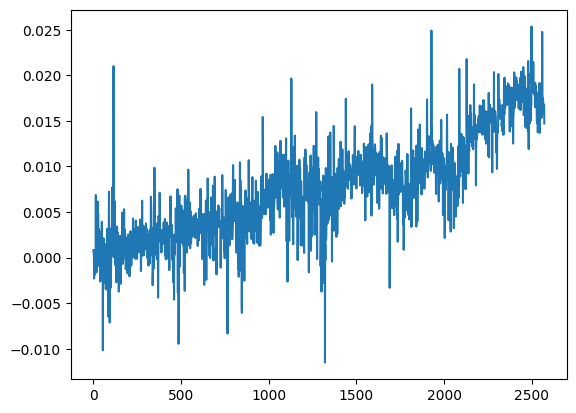

In [51]:
plt.plot(percent_deviations)